In [1]:
#Module for plotting results only!

import sys
import os
import glob
import gdal
import rasterstats
import rasterio
from rasterstats import zonal_stats
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
from shapely.geometry import shape
import shapely.wkt
import string
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import datetime
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Javascript, display, clear_output
import ipywidgets as widgets
from tqdm import tqdm_notebook as tqdm
import matplotlib.dates as mdates
from scipy.signal import gaussian
from scipy.ndimage import filters
from affine import Affine
import CometTS  #See ComeTS.py to edit functions
from CometTS import *

### Run plotting from CSV output ONLY

input_CSV="/AOI_InterestingPlaces_SWIR2/NO_InterestingPlaces_UTM_FullStats.csv"
input_CSV2="/AOI_Interesting_Places_Green/NO_InterestingPlaces_UTM_FullStats.csv"
input_CSV3="/AOI_InterestingPlaces_NIR/NO_InterestingPlaces_UTM_FullStats.csv"
%matplotlib inline

def gen_dual_plot(input_csv, input_csv2, title_label= "Spectral Response Over Time - ID: "):
    CSVs=[input_csv,input_csv2]
    gdfs=["gdf_1","gdf_2"]
    count=0
    for csv in CSVs:
        df = pd.read_csv(csv)
        df=df.sort_values(['date'])
        geometry = df['geometry'].map(shapely.wkt.loads)
        crs = {'init': 'epsg:2263'}
        gdfs[count] = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
        gdfs[count]['date']=pd.to_datetime(gdfs[count]['date'],infer_datetime_format=True)
        count+=1
    run_dual_plot(gdfs[0],gdfs[1],title_label=title_label,show_grid=False, ymax=3000, 
                  y_label="Surface Reflectance x 10000")

def gen_tri_plot(input_csv, input_csv2, input_csv3, title_label= "Spectral Response Over Time - ID: "):
    CSVs=[input_csv,input_csv2,input_csv3]
    gdfs=["gdf_1","gdf_2","gdf_3"]
    count=0
    for csv in CSVs:
        df = pd.read_csv(csv)
        df=df.sort_values(['date'])
        geometry = df['geometry'].map(shapely.wkt.loads)
        crs = {'init': 'epsg:2263'}
        gdfs[count] = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
        gdfs[count]['date']=pd.to_datetime(gdfs[count]['date'],infer_datetime_format=True)
        count+=1
    run_tri_plot(gdfs[0],gdfs[1],gdfs[2],title_label=title_label,show_grid=False, ymax=5000, 
                  y_label="Surface Reflectance x 10000")
    
    

        

#def gen_plots(input_csv, title_label= "Spectral Response Over Time - ID: "):
#    df = pd.read_csv(input_csv)
#    df=df.sort_values(['date'])
#    geometry = df['geometry'].map(shapely.wkt.loads)
#    crs = {'init': 'epsg:2263'}
#    gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
#    gdf['date']=pd.to_datetime(gdf['date'],infer_datetime_format=True)
#    run_plot(gdf, y_label="Surface Reflectance x 10000", title_label=title_label,
#             show_grid=False,ymin=0,ymax=3000)
#    #run_plot(gdf)
#
#gen_plots(input_CSV, title_label= "SWIR2 Response Over Time - ID: ")
#gen_plots(input_CSV2, title_label= "NIR Response Over Time - ID: ")

In [2]:
def run_dual_plot(main_gdf,gdf2, figsize = (12,6), y_val_alpha = 1, scatter_alpha = 1, 
             error_alpha = 0.2, y_label = "Brightness", x_label = "Date", title_label= "Brightness over time - ID: " 
             ,figname = '', custom_x_axis = True, show_grid = True, show_legend = True, min_count=0.5,ymin=0,ymax=5000):
    print "Plotting..." 
    for item in main_gdf['ID'].unique() & gdf2['ID'].unique():
        plt.style.use('fivethirtyeight')
        fig, ax = plt.subplots(figsize=figsize)
        gdf3=main_gdf[(main_gdf.ID == item)]
        gdf4=gdf2[(gdf2.ID == item)]
        title= title_label + str(item)
        gdf3=gdf3.sort_values(['date'])
        gdf4=gdf4.sort_values(['date'])
        x = gdf3['date']
        xdate= x.astype('O')
        xdate=mdates.date2num(xdate)
        y  = gdf3['median']
        y2 = gdf4['median']
        #print(y,y2)
        if 'observations' in gdf3.columns:
            count= gdf3['observations']
        err_plus = gdf3['percentile_75']
        err_minus = gdf3['percentile_25']
        if 'observations' in gdf4.columns:
            count2= gdf4['observations']
        err_plus2 = gdf4['percentile_75']
        err_minus2 = gdf4['percentile_25']
        #Set the min_count value as a value from 0 to 1 (0 to 100%)
        ax.set_ylim([ymin,ymax])
        
        #This will filter out observations where over n% of a polygon is masked out
        if min_count > 0:
            z = gdf3['count']
            zmax=gdf3['count'].max()
            z=z/zmax
            #xdate = xdate[z >= min_count]
            y = y[z >= min_count]
            if 'observations' in gdf3.columns:
                count=count[z>= min_count]
            err_plus = err_plus[z >= min_count]
            err_minus = err_minus[z >= min_count]
            
            z2 = gdf4['count']
            zmax2=gdf4['count'].max()
            z2=z2/zmax2
            xdate = xdate[z >= min_count]
            y2 = y2[z2 >= min_count]
            if 'observations' in gdf4.columns:
                count2=count2[z2>= min_count]
            err_plus2 = err_plus2[z2 >= min_count]
            err_minus2 = err_minus2[z2 >= min_count]


       
        #plot running mean regression line
        RM=(y.rolling(window=6,center=True, min_periods=2).median())
        #ax.plot(xdate, RM, '-',label="Moving Median", alpha=y_val_alpha)

        #Gaussian smoothed plot
        b = gaussian(6, 2)
        ga = filters.convolve1d(y, b/b.sum(),mode="reflect")
        ga=interpolate_gaps(ga, limit=3)
        ax.plot(xdate, ga, '-',label="Gaussian Smoothed", alpha=1, color='#d7191c')
        
        ga2 = filters.convolve1d(y2, b/b.sum(),mode="reflect")
        ga2=interpolate_gaps(ga2, limit=3)
        ax.plot(xdate, ga2, '-',label="Gaussian Smoothed_2", alpha=1, color='#2b83ba')

        # scatter points-median top, mean bottom
        ax.scatter(xdate, y, label="Median", s=50, color='#d7191c', alpha=scatter_alpha, marker=".")
        ax.scatter(xdate, y2, label="Median_2", s=50, color='#2b83ba', alpha=scatter_alpha, marker=".")
        
         # plot regression line, if desired
        idx = np.isfinite(xdate) & np.isfinite(y)
        p2 = np.poly1d(np.polyfit(xdate[idx], y[idx], 1))
        ax.plot(xdate, p2(xdate), '-',label="Linear Regression", color='#E84448', alpha=y_val_alpha)
        
        idx = np.isfinite(xdate) & np.isfinite(y2)
        p3 = np.poly1d(np.polyfit(xdate[idx], y2[idx], 1))
        ax.plot(xdate, p3(xdate), '-',label="Linear Regression_2", color='#4B97C8', alpha=y_val_alpha)
       

        # if desired, plot error band
        #plt.fill_between(xdate, err_plus, err_minus, alpha=error_alpha, color='black', label="25th to 75th %")
        #plt.fill_between(xdate, err_plus2, err_minus2, alpha=error_alpha, color='black', label="25th to 75th %")

        ax.set_ylabel(y_label)
        ax.set_xlabel(x_label)
        
        
        ax.yaxis.set_tick_params(labelsize=12)
        if custom_x_axis:
            xticklabel_pad = 0.1
            years = mdates.YearLocator()   # every year
            months = mdates.MonthLocator()  # every month
            yearsFmt = mdates.DateFormatter('%Y')
            

            ax.xaxis.set_major_locator(years)
            ax.xaxis.set_major_formatter(yearsFmt)
            ax.xaxis.set_minor_locator(months)
            
            plt.rc('xtick', labelsize=12)
            
            #ax.set_xticks(xdate)
            #ax.set_xticklabels(x, rotation=50, fontsize=10)
            #ax.tick_params(axis='x', which='major', pad=xticklabel_pad)
            
            #ax.xaxis.set_major_formatter(dateformat)
            #ax.set_xlim(datetime.date(settings.plot['x_min'], 1, 1),datetime.date(settings.plot['x_max'], 12, 31))

        if show_grid:
            ax.grid(b=True, which='minor', color='black', alpha=0.75, linestyle=':')


        if show_legend:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels, ncol=1, loc='center right', 
               bbox_to_anchor=[1.1, 0.5], 
               columnspacing=1.0, labelspacing=0.0,
               handletextpad=0.0, handlelength=1.5,
               fancybox=True, shadow=True,
               fontsize='x-small')   

        ax.set_title(title)
        plt.tight_layout()
        plt.show()

        # save with figname
        if len(figname) > 0:
            plt.savefig(figname, dpi=dpi)




In [3]:
def run_tri_plot(main_gdf,gdf2, gdfx, figsize = (12,6), y_val_alpha = 1, scatter_alpha = 1, 
             error_alpha = 0.2, y_label = "Brightness", x_label = "Date", title_label= "Brightness over time - ID: " 
             ,figname = '', custom_x_axis = True, show_grid = True, show_legend = True, min_count=0.5,ymin=0,ymax=5000):
    print "Plotting..." 
    for item in main_gdf['ID'].unique() & gdf2['ID'].unique():
        plt.style.use('fivethirtyeight')
        fig, ax = plt.subplots(figsize=figsize)
        gdf3=main_gdf[(main_gdf.ID == item)]
        gdf4=gdf2[(gdf2.ID == item)]
        gdf5=gdfx[(gdfx.ID == item)]
        title= title_label + str(item)
        gdf3=gdf3.sort_values(['date'])
        gdf4=gdf4.sort_values(['date'])
        gdf5=gdf5.sort_values(['date'])
        x = gdf3['date']
        xdate= x.astype('O')
        xdate=mdates.date2num(xdate)
        y  = gdf3['median']
        y2 = gdf4['median']
        y3 = gdf5['median']
        #print(y,y2)
        if 'observations' in gdf3.columns:
            count= gdf3['observations']
        err_plus = gdf3['percentile_75']
        err_minus = gdf3['percentile_25']
        if 'observations' in gdf4.columns:
            count2= gdf4['observations']
        err_plus2 = gdf4['percentile_75']
        err_minus2 = gdf4['percentile_25']
        
        if 'observations' in gdf5.columns:
            count3= gdf5['observations']
        err_plus3 = gdf5['percentile_75']
        err_minus3 = gdf5['percentile_25']
        #Set the min_count value as a value from 0 to 1 (0 to 100%)
        ax.set_ylim([ymin,ymax])
        
        #This will filter out observations where over n% of a polygon is masked out
        if min_count > 0:
            z = gdf3['count']
            zmax=gdf3['count'].max()
            z=z/zmax
            #xdate = xdate[z >= min_count]
            y = y[z >= min_count]
            if 'observations' in gdf3.columns:
                count=count[z>= min_count]
            err_plus = err_plus[z >= min_count]
            err_minus = err_minus[z >= min_count]
            
            z2 = gdf4['count']
            zmax2=gdf4['count'].max()
            z2=z2/zmax2
            #xdate = xdate[z >= min_count]
            y2 = y2[z2 >= min_count]
            
            
            if 'observations' in gdf4.columns:
                count2=count2[z2>= min_count]
            err_plus2 = err_plus2[z2 >= min_count]
            err_minus2 = err_minus2[z2 >= min_count]
            
            z3 = gdf5['count']
            zmax3=gdf5['count'].max()
            z3=z3/zmax3
            xdate = xdate[z >= min_count]
            y3 = y3[z3 >= min_count]
            
            if 'observations' in gdf5.columns:
                count3=count3[z3>= min_count]
            err_plus3 = err_plus3[z3 >= min_count]
            err_minus3 = err_minus3[z3 >= min_count]



       
        #plot running mean regression line
        RM=(y.rolling(window=6,center=True, min_periods=2).median())
        #ax.plot(xdate, RM, '-',label="Moving Median", alpha=y_val_alpha)

        #Gaussian smoothed plot
        b = gaussian(6, 2)
        ga = filters.convolve1d(y, b/b.sum(),mode="reflect")
        ga=interpolate_gaps(ga, limit=3)
        ax.plot(xdate, ga, '-',label="Gaussian SWIR2", alpha=1, color='#d7191c')
        
        ga2 = filters.convolve1d(y2, b/b.sum(),mode="reflect")
        ga2=interpolate_gaps(ga2, limit=3)
        ax.plot(xdate, ga2, '-',label="Gaussian Green", alpha=1, color='#44C73D')
        
        ga3 = filters.convolve1d(y3, b/b.sum(),mode="reflect")
        ga3=interpolate_gaps(ga3, limit=3)
        ax.plot(xdate, ga3, '-',label="Gaussian NIR", alpha=1, color='#2b83ba')

        # scatter points-median top, mean bottom
        ax.scatter(xdate, y, label="Median SWIR2", s=50, color='#d7191c', alpha=scatter_alpha, marker=".")
        ax.scatter(xdate, y2, label="Median Green", s=50, color='#44C73D', alpha=scatter_alpha, marker=".")
        ax.scatter(xdate, y3, label="Median NIR", s=50, color='#2b83ba', alpha=scatter_alpha, marker=".")
        
         # plot regression line, if desired
        idx = np.isfinite(xdate) & np.isfinite(y)
        p2 = np.poly1d(np.polyfit(xdate[idx], y[idx], 1))
        ax.plot(xdate, p2(xdate), '-',label="Linear SWIR2", color='#E84448', alpha=y_val_alpha)
        
        idx = np.isfinite(xdate) & np.isfinite(y2)
        p3 = np.poly1d(np.polyfit(xdate[idx], y2[idx], 1))
        ax.plot(xdate, p3(xdate), '-',label="Linear Green", color='#65D75F', alpha=y_val_alpha)
        
        idx = np.isfinite(xdate) & np.isfinite(y3)
        p4 = np.poly1d(np.polyfit(xdate[idx], y3[idx], 1))
        ax.plot(xdate, p4(xdate), '-',label="Linear NIR", color='#4B97C8', alpha=y_val_alpha)
       

        # if desired, plot error band
        #plt.fill_between(xdate, err_plus, err_minus, alpha=error_alpha, color='black', label="25th to 75th %")
        #plt.fill_between(xdate, err_plus2, err_minus2, alpha=error_alpha, color='black', label="25th to 75th %")

        ax.set_ylabel(y_label)
        ax.set_xlabel(x_label)
        
        
        ax.yaxis.set_tick_params(labelsize=12)
        if custom_x_axis:
            xticklabel_pad = 0.1
            years = mdates.YearLocator()   # every year
            months = mdates.MonthLocator()  # every month
            yearsFmt = mdates.DateFormatter('%Y')
            

            ax.xaxis.set_major_locator(years)
            ax.xaxis.set_major_formatter(yearsFmt)
            ax.xaxis.set_minor_locator(months)
            
            plt.rc('xtick', labelsize=12)
            
            #ax.set_xticks(xdate)
            #ax.set_xticklabels(x, rotation=50, fontsize=10)
            #ax.tick_params(axis='x', which='major', pad=xticklabel_pad)
            
            #ax.xaxis.set_major_formatter(dateformat)
            #ax.set_xlim(datetime.date(settings.plot['x_min'], 1, 1),datetime.date(settings.plot['x_max'], 12, 31))

        if show_grid:
            ax.grid(b=True, which='minor', color='black', alpha=0.75, linestyle=':')


        if show_legend:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels, ncol=1, loc='center right', 
               bbox_to_anchor=[1.1, 0.5], 
               columnspacing=1.0, labelspacing=0.0,
               handletextpad=0.0, handlelength=1.5,
               fancybox=True, shadow=True,
               fontsize='x-small')   

        ax.set_title(title)
        plt.tight_layout()
        plt.show()

        # save with figname
        if len(figname) > 0:
            plt.savefig(figname, dpi=dpi)

Plotting...


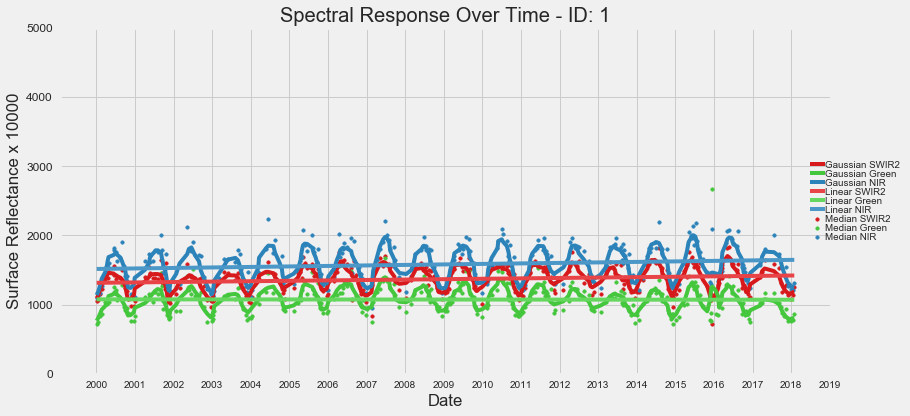

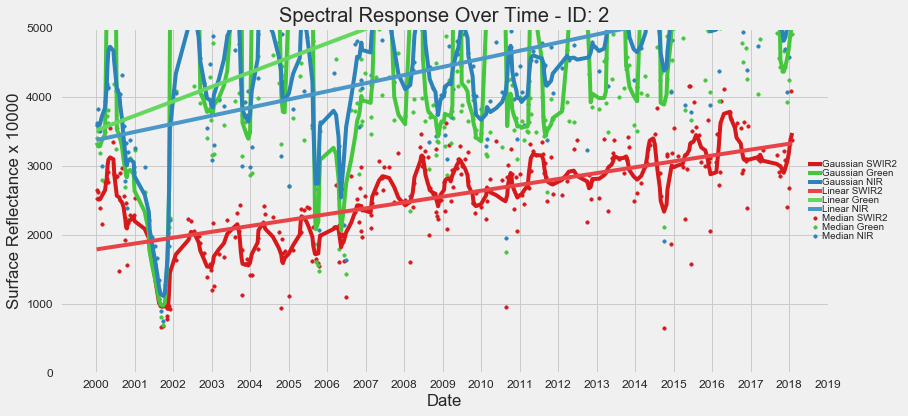

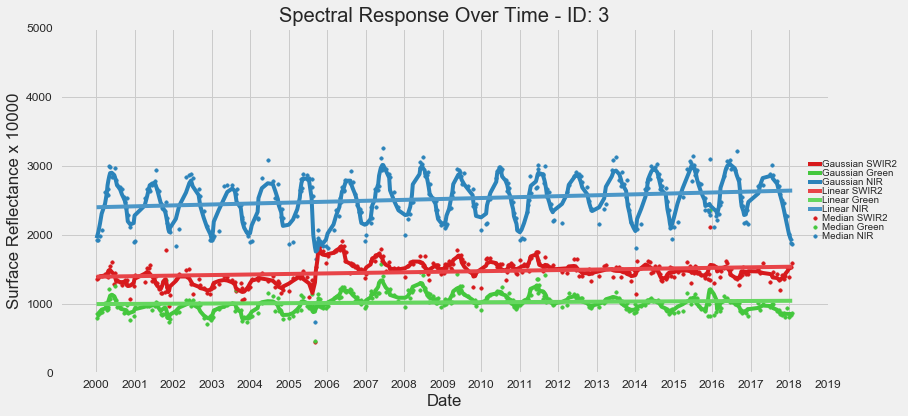

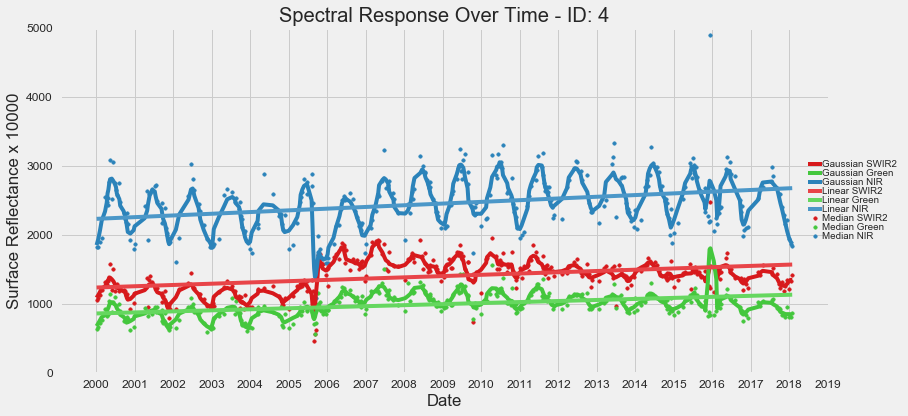

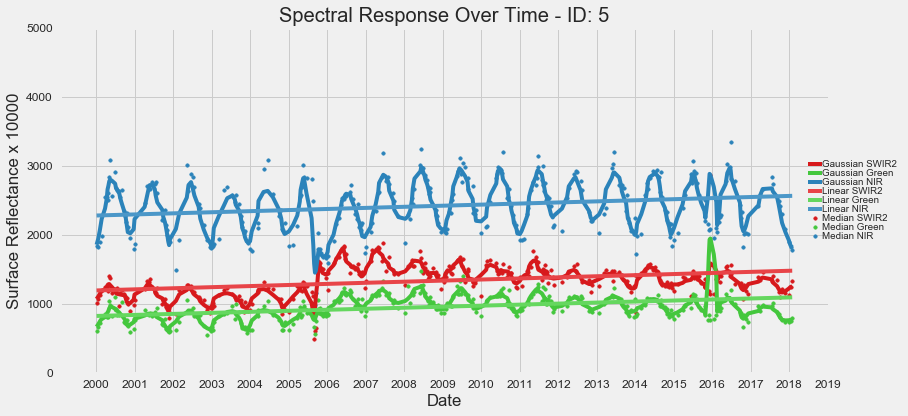

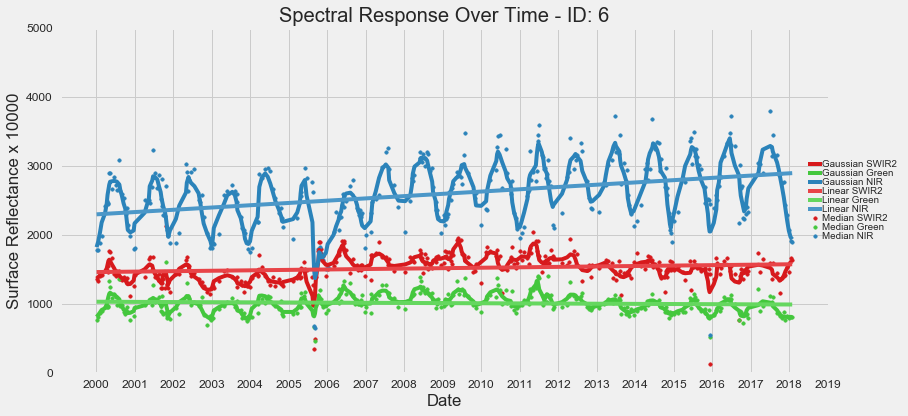

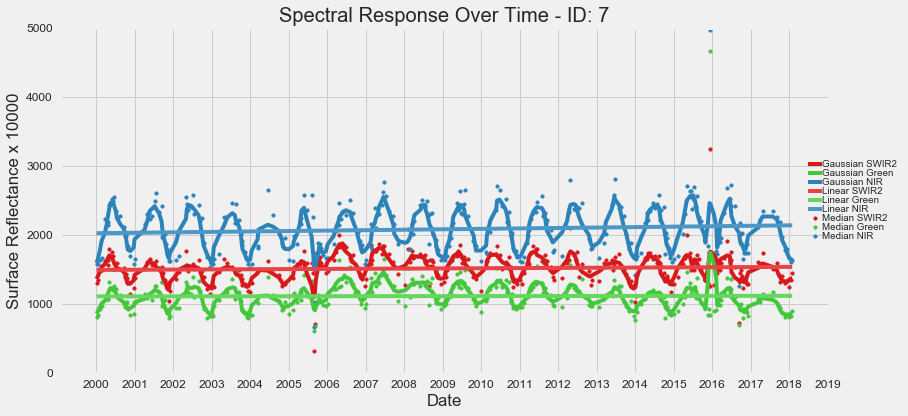

In [4]:
gen_tri_plot(input_CSV, input_CSV2, input_CSV3, title_label= "Spectral Response Over Time - ID: ")

Plotting...


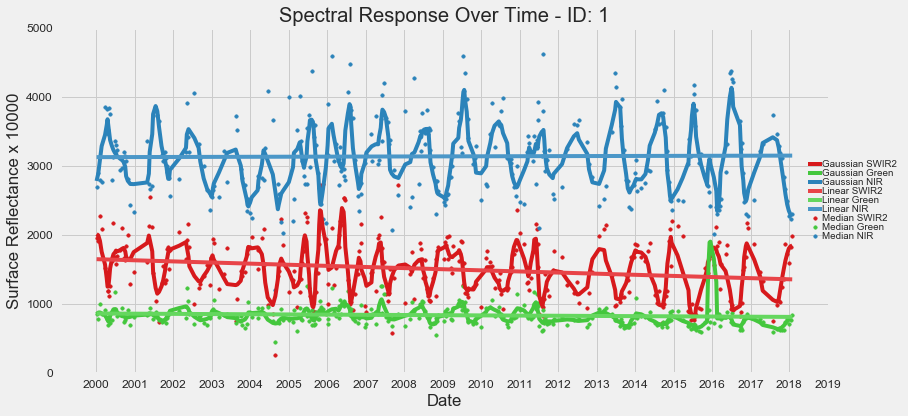

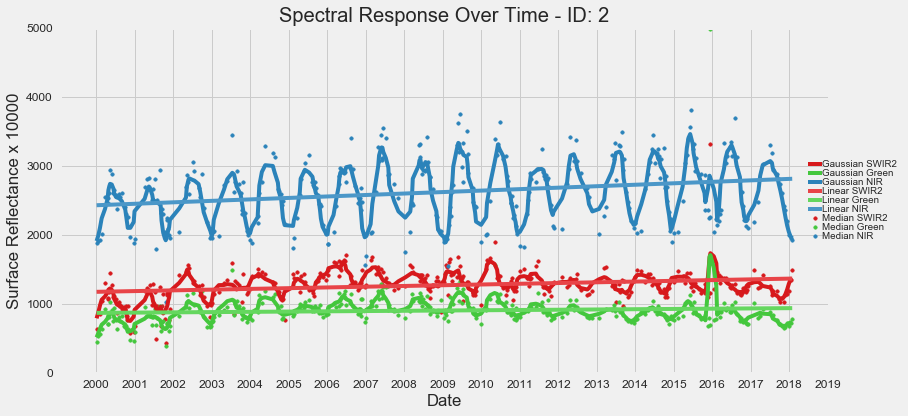

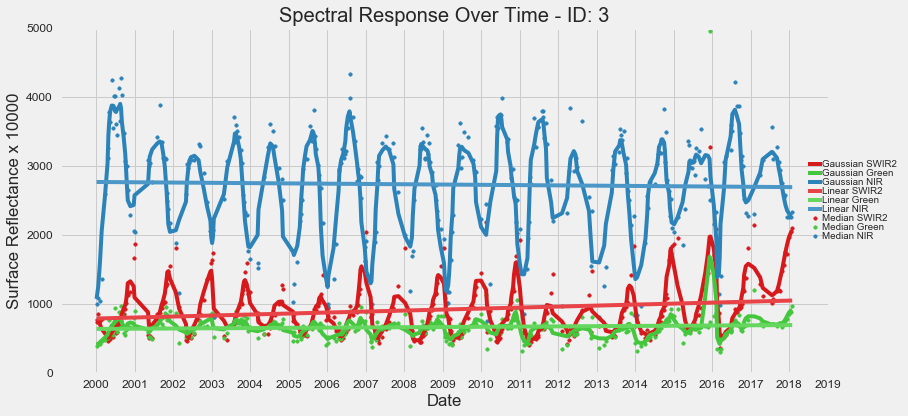

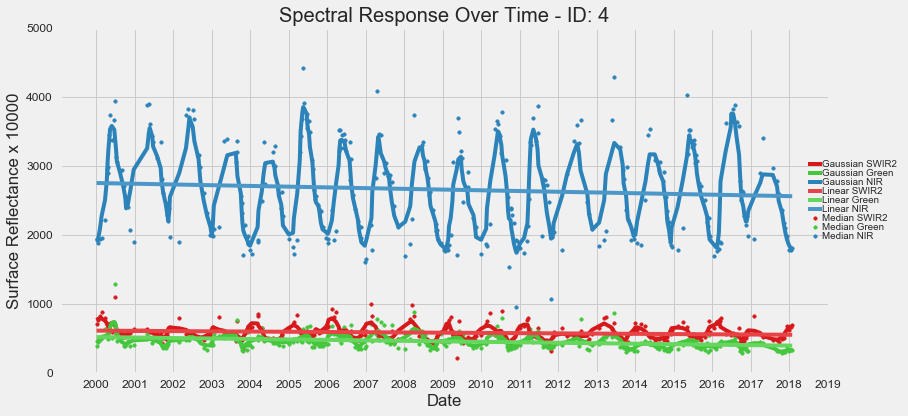

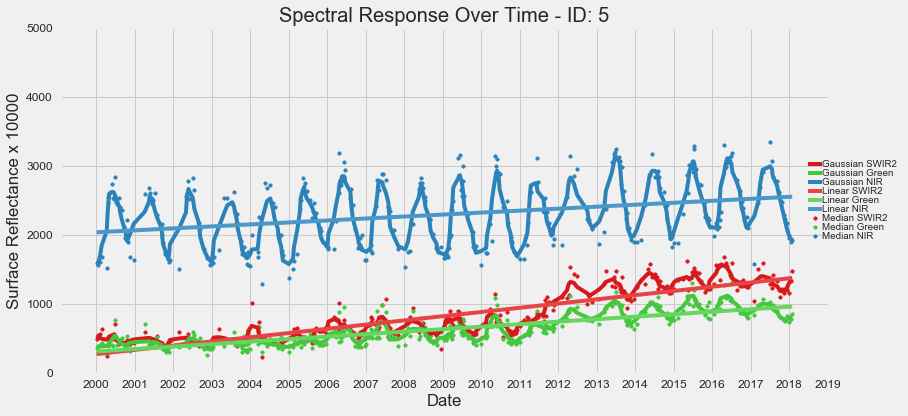

In [6]:
gen_tri_plot(input_CSV, input_CSV2, input_CSV3, title_label= "Spectral Response Over Time - ID: ")